# SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [9]:
scaler = StandardScaler()

In [10]:
df.loc[:,"Phi_0":"MedianTheta"] = scaler.fit_transform(df.loc[:,"Phi_0":"MedianTheta"])

In [11]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,7.146661e-17,-2.706296e-16,-7.705465e-16,-3.355171e-16,-2.781065e-16,8.641905e-16,6.533453e-16,3.205695e-16,2.842518e-17,...,0.0,0.0,0.0,0.0,-4.221603e-17,-8.916758e-18,1.504040e-16,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,-2.112098e+00,-2.590963e+00,-2.573098e+00,-2.576017e+00,-1.583825e+00,-1.538390e+00,-1.519067e+00,-1.435270e+00,-8.901182e+00,...,0.0,0.0,0.0,0.0,-2.124623e+00,-9.920352e-01,-2.498105e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,-8.339083e-01,-8.378547e-01,-8.368982e-01,-8.379445e-01,-8.268486e-01,-8.554224e-01,-8.339413e-01,-8.469162e-01,-7.401255e-01,...,0.0,0.0,0.0,0.0,-5.217347e-01,-9.920352e-01,-8.459116e-01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,-1.214813e-02,-1.374387e-02,-1.370004e-02,-1.385850e-02,-1.644940e-01,-1.724547e-01,-1.488154e-01,-1.605036e-01,-3.750902e-03,...,0.0,0.0,0.0,0.0,1.256146e-02,-7.392128e-02,-4.794768e-03,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,8.312126e-01,8.159859e-01,8.094982e-01,8.121005e-01,6.871047e-01,7.056466e-01,6.341855e-01,7.220270e-01,7.326237e-01,...,0.0,0.0,0.0,0.0,5.468577e-01,8.441926e-01,8.062822e-01,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,1.949746e+00,1.913552e+00,1.909590e+00,1.911506e+00,2.958035e+00,2.754550e+00,3.276814e+00,3.173501e+00,9.511558e+00,...,0.0,0.0,0.0,0.0,2.149746e+00,2.680420e+00,1.887718e+00,4.999991e-01,3.141592e+00,2.493834e+00


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [12]:
features = list(df.columns)[1:29]
features

['Phi_0',
 'Phi_2',
 'Phi_3',
 'Phi_4',
 'Theta_0',
 'Theta_2',
 'Theta_3',
 'Theta_4',
 'BendingAngle_0',
 'BendingAngle_2',
 'BendingAngle_3',
 'BendingAngle_4',
 'TimeInfo_0',
 'TimeInfo_2',
 'TimeInfo_3',
 'TimeInfo_4',
 'RingNumber_0',
 'RingNumber_2',
 'RingNumber_3',
 'RingNumber_4',
 'Front_0',
 'Front_2',
 'Front_3',
 'Front_4',
 'Mask_0',
 'Mask_2',
 'Mask_3',
 'Mask_4']

In [13]:
# Lets split the data into train and the test splits

In [14]:
train_idx, test_idx = train_test_split(df['Unnamed: 0'].to_numpy(), test_size = 0.2, random_state = 1)
x_data = df[features].to_numpy()
pT = abs(1/df.loc[:,'q/pt']).to_numpy()
label = pT
num_features = x_data.shape[-1]
print('Data shape: ' + str(x_data.shape))
print(pT.shape)
print('Len train: '+str(len(train_idx))+', Len test: '+str(len(test_idx)))
print('Num. features: '+str(num_features))

Data shape: (1179356, 28)
(1179356,)
Len train: 943484, Len test: 235872
Num. features: 28


In [15]:
label.min(), label.max()

(2.00000380000722, 6955.5709428241635)

# Dataset Class and Data Loaders

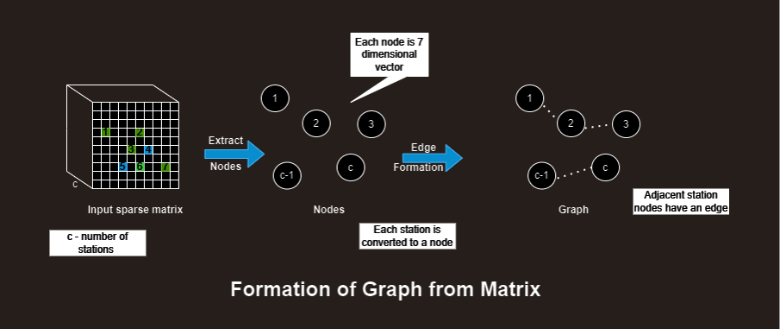

**The dataset is having 28 features extracted from 4 triggers ie 7 features per trigger**

**Total approached to try**

---------------------------------------------------------------------------------------------------------------------------
**(THIS NOTEBOOK)**

- [x] **Each station as a node : 
    Here basically each station(4),is made a node of the graph and the node feature is the features recieved at the respective station(7)**
    
    Here,
         Total nodes = 4
         node feature length = 7
         edges should be between these 4 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
    
    
---------------------------------------------------------------------------------------------------------------------------
- [ ] **Each feature as a node :
    Here basically each feature obtianed from different stations, here 4 stations are made a node of the graph and 
    the node feature is the values of this feature across the 4 different stations**
    
    Here,
         Total nodes = 7
         node feature length = 4
         edges should be between these 7 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
         
---------------------------------------------------------------------------------------------------------------------------

- [ ]  **Each patch as a node :
    Here basically the data is converted into 7*4 matrix and then would have to split this into patches and then the features of the noden would be the flattened pixel values in each patch**
    
    Here,
         Total nodes = total_patches 
         node feature length = pixels in each path
         edges should be between these patch nodes (Yet to find out the best way to decide across which two nodes there should be and edge
         
---------------------------------------------------------------------------------------------------------------------------

In [16]:
# x_data.shape

In [17]:
class Graph_dataset(Dataset):
    def __init__(self, dataset , label,  edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = edge_index
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
    
        data = Data(x=torch.tensor(self.data[i].reshape(-1,4).T, dtype=torch.float), y=torch.tensor(self.label[i], dtype=torch.float),
                    edge_index=torch.tensor(self.edge_index, dtype = torch.long).T)
        return data

In [18]:
edge_index = [(0,1),(1,2),(2,3),(3,2),(2,1),(1,0)]

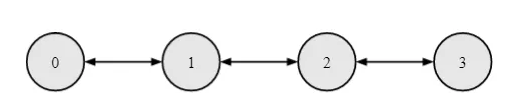

In [19]:
train_dataset = Graph_dataset(x_data, label, edge_index , train_idx)
next(iter(train_dataset))

Data(x=[4, 7], edge_index=[2, 6], y=9.726032257080078)

In [20]:
train_loader = DataLoader(Graph_dataset(x_data, label, edge_index , train_idx), batch_size=1024)
test_loader = DataLoader(Graph_dataset(x_data, label, edge_index , test_idx), batch_size=512)

In [21]:
next(iter(train_loader))

DataBatch(x=[4096, 7], edge_index=[2, 6144], y=[1024], batch=[4096], ptr=[1025])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [22]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()
        self.conv1 = GCNConv(int(len(features)/4),128 )
        self.conv2 = GCNConv(128,64)
        self.conv3 = GCNConv(64,64 )
        self.conv4 = GCNConv(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x

In [24]:
# Example usage:
# Initialize your model
model = MODEL_GNN()

In [25]:
model

MODEL_GNN(
  (conv1): GCNConv(7, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16, out_features=1, bias=True)
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
)

In [26]:
# Forward pass with input data x and edge_index

In [27]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('MSEError: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = pTLossTorch(out, data.y)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training pTLoss: ', train_loss, '| Testing pTLoss: ', test_loss)
        
        if prog_bar:
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [28]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

In [29]:
name =  f"4GCN_Conv"

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from inf to 4.8436048180834606
Epoch:  1/50 | Training pTLoss:  6.947498925078727 | Testing pTLoss:  4.8436048180834606


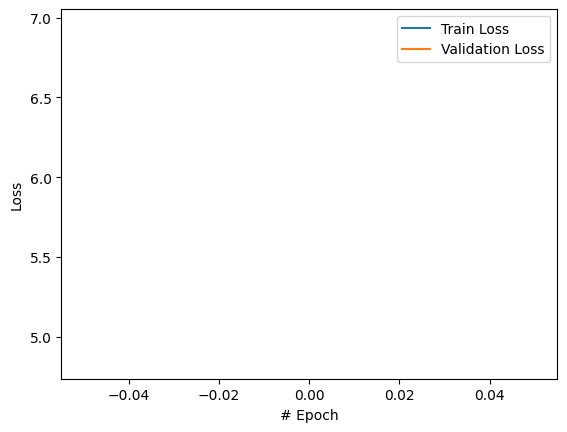

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.8436048180834606 to 4.5630118063370215
Epoch:  2/50 | Training pTLoss:  4.88318000439708 | Testing pTLoss:  4.5630118063370215


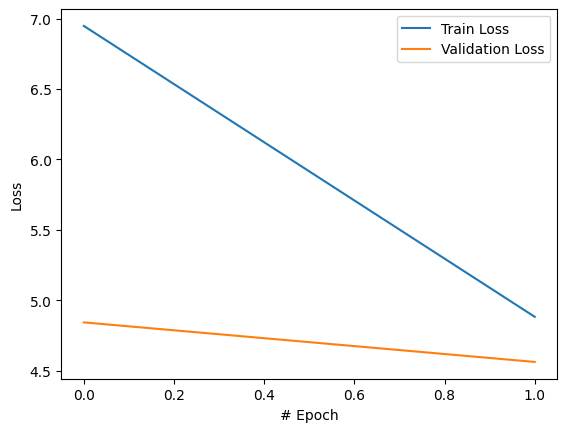

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.5630118063370215 to 4.125051351276243
Epoch:  3/50 | Training pTLoss:  4.503155252292195 | Testing pTLoss:  4.125051351276243


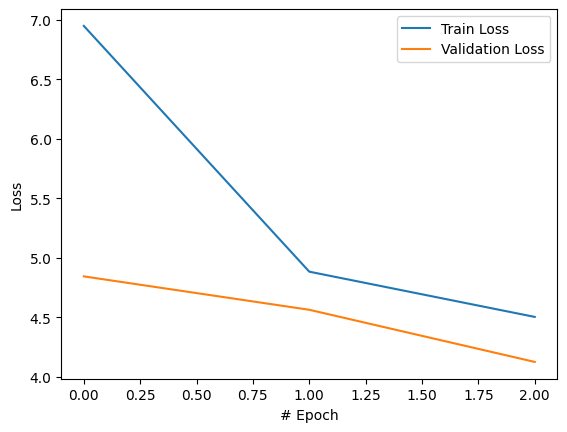

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.125051351276243 to 4.011046358147824
Epoch:  4/50 | Training pTLoss:  4.206806557943918 | Testing pTLoss:  4.011046358147824


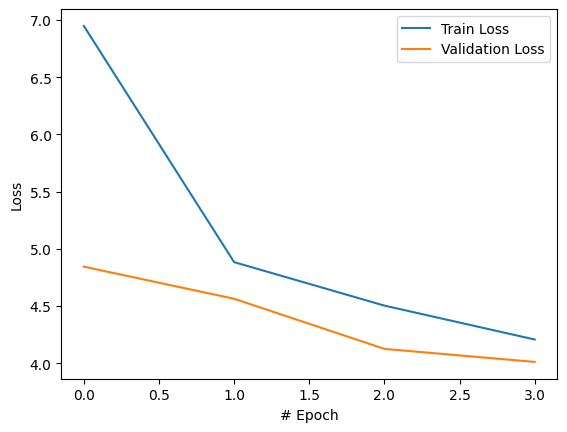

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 4.011046358147824 to 3.9738571351624365
Epoch:  5/50 | Training pTLoss:  4.1206989835244725 | Testing pTLoss:  3.9738571351624365


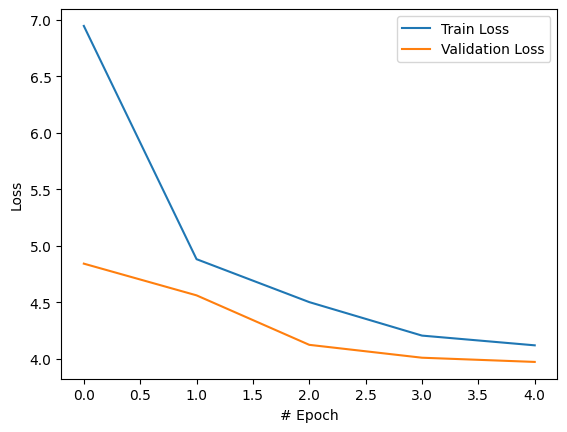

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  6/50 | Training pTLoss:  4.082111455613253 | Testing pTLoss:  3.9825305258632993


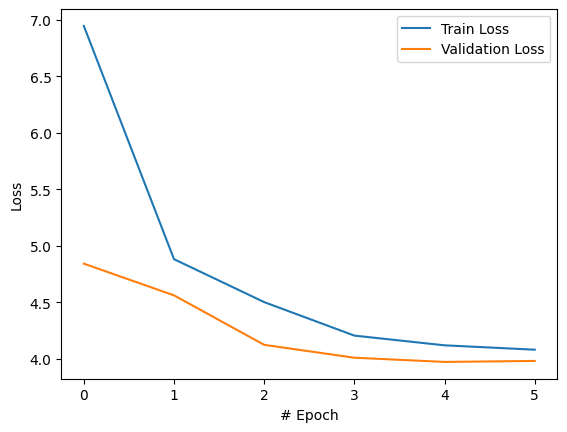

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  7/50 | Training pTLoss:  4.062462259916312 | Testing pTLoss:  3.976678990490266


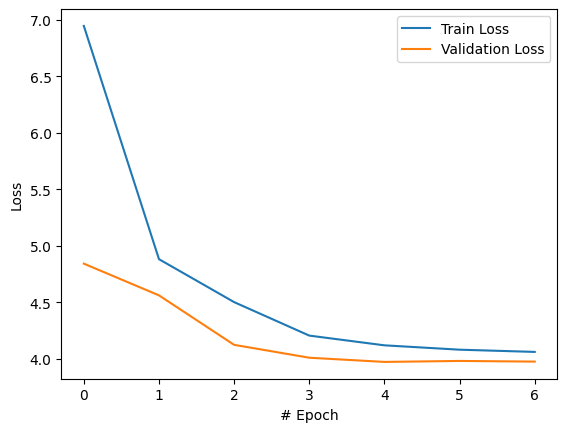

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9738571351624365 to 3.9176436719563443
Epoch:  8/50 | Training pTLoss:  4.002158046415212 | Testing pTLoss:  3.9176436719563443


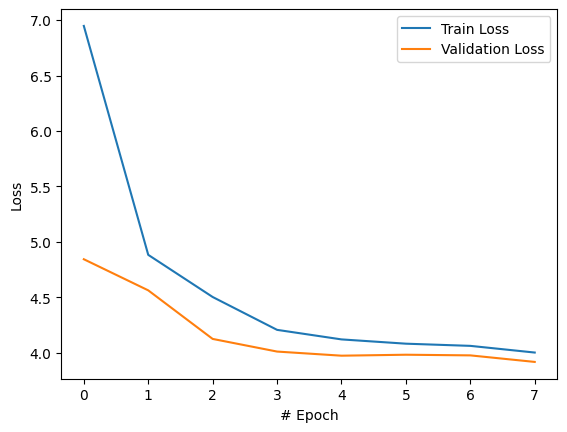

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9176436719563443 to 3.916052885531343
Epoch:  9/50 | Training pTLoss:  3.994120539527657 | Testing pTLoss:  3.916052885531343


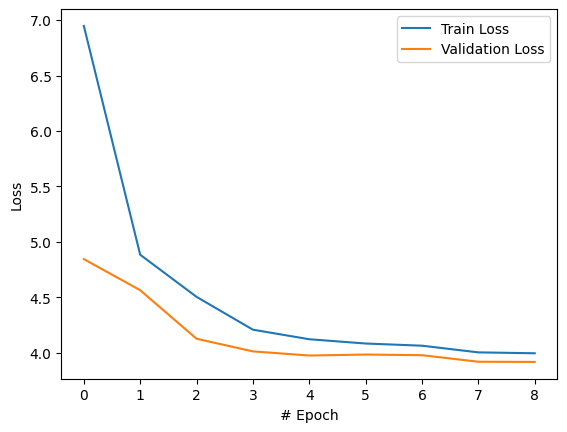

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.916052885531343 to 3.914389348081806
Epoch:  10/50 | Training pTLoss:  3.9874080601845305 | Testing pTLoss:  3.914389348081806


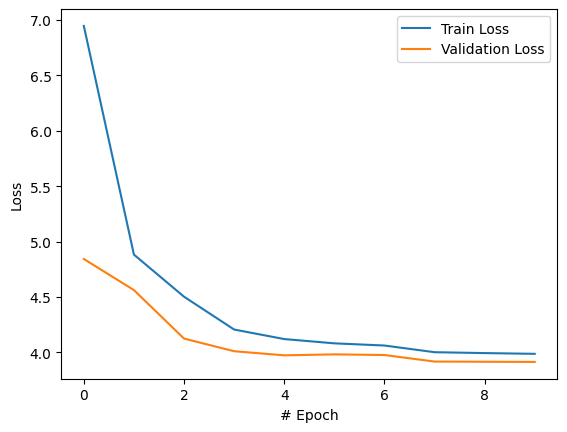

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  11/50 | Training pTLoss:  3.9848018258874642 | Testing pTLoss:  3.9157975950882378


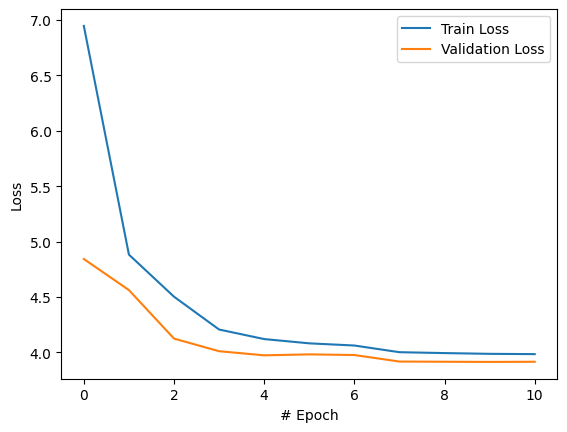

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.914389348081806 to 3.910222046804533
Epoch:  12/50 | Training pTLoss:  3.9808681604660525 | Testing pTLoss:  3.910222046804533


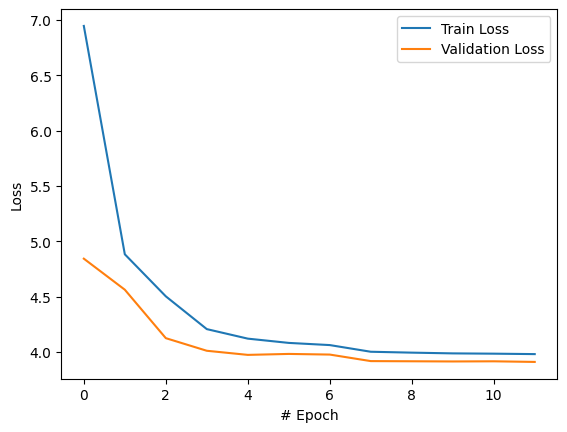

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.910222046804533 to 3.9051267818877107
Epoch:  13/50 | Training pTLoss:  3.9789967993334954 | Testing pTLoss:  3.9051267818877107


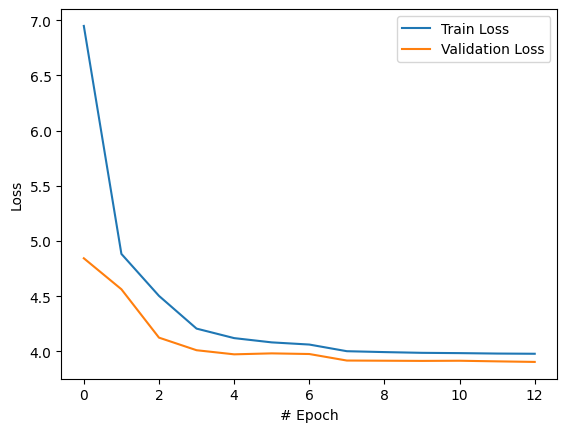

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  14/50 | Training pTLoss:  3.9746746373021455 | Testing pTLoss:  3.913154142280457


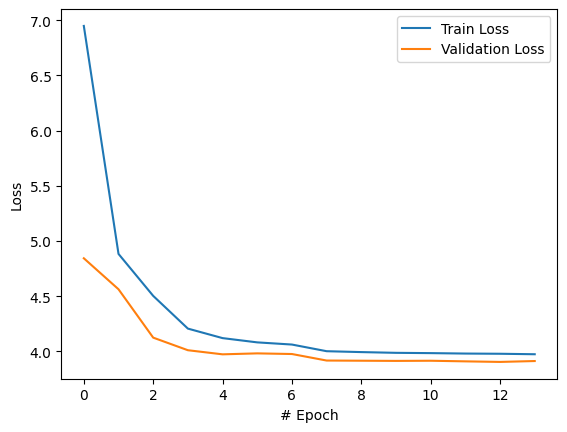

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  15/50 | Training pTLoss:  3.9726705193002387 | Testing pTLoss:  3.9096776629735475


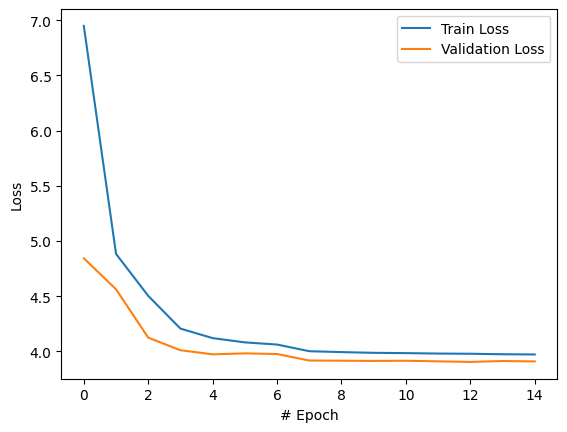

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.9051267818877107 to 3.8767603728879805
Epoch:  16/50 | Training pTLoss:  3.943995401295559 | Testing pTLoss:  3.8767603728879805


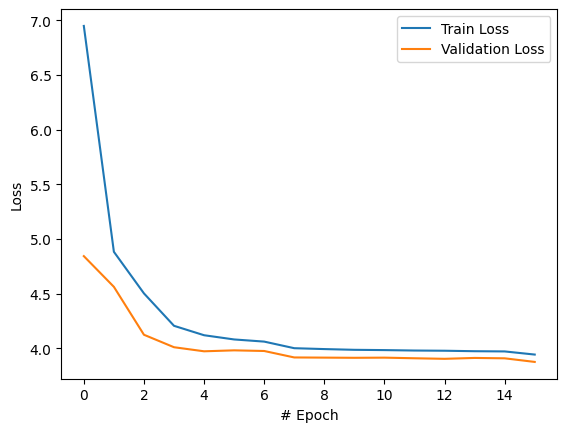

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8767603728879805 to 3.8766055719971395
Epoch:  17/50 | Training pTLoss:  3.9399067220356887 | Testing pTLoss:  3.8766055719971395


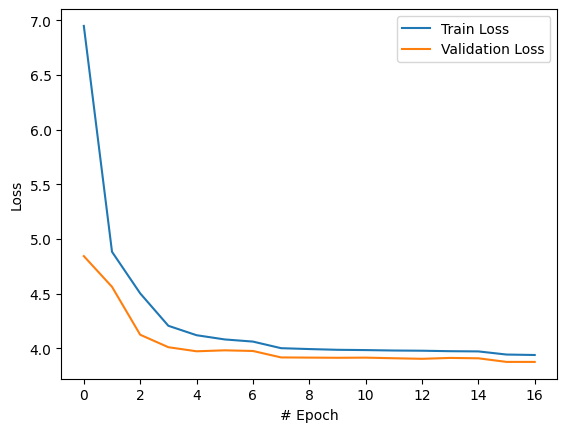

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  18/50 | Training pTLoss:  3.9387561738361736 | Testing pTLoss:  3.877596131374415


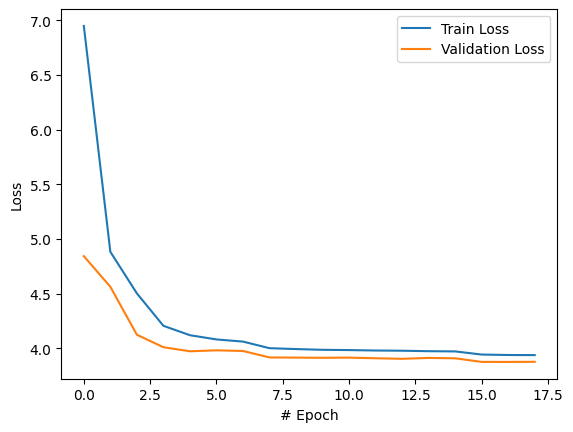

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8766055719971395 to 3.8568498576282186
Epoch:  19/50 | Training pTLoss:  3.921305585321277 | Testing pTLoss:  3.8568498576282186


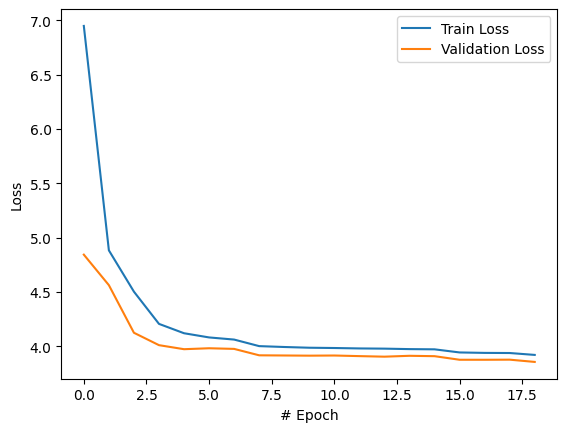

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8568498576282186 to 3.856256144424323
Epoch:  20/50 | Training pTLoss:  3.9187893938604472 | Testing pTLoss:  3.856256144424323


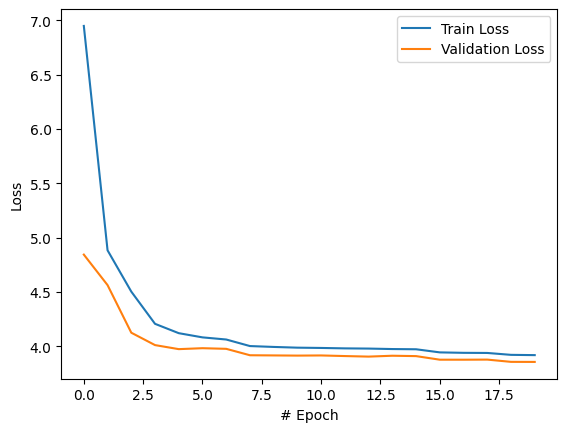

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.856256144424323 to 3.8555143249267587
Epoch:  21/50 | Training pTLoss:  3.917570317515581 | Testing pTLoss:  3.8555143249267587


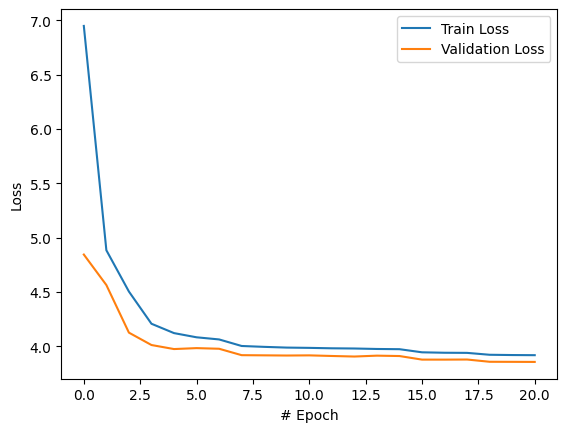

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8555143249267587 to 3.85485461709815
Epoch:  22/50 | Training pTLoss:  3.916540552375113 | Testing pTLoss:  3.85485461709815


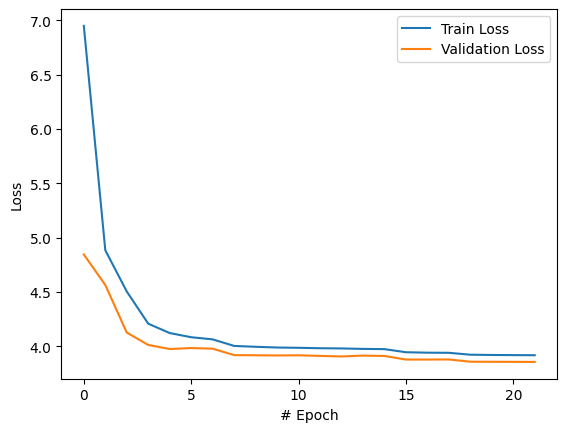

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.85485461709815 to 3.8545781190379804
Epoch:  23/50 | Training pTLoss:  3.9155692037946483 | Testing pTLoss:  3.8545781190379804


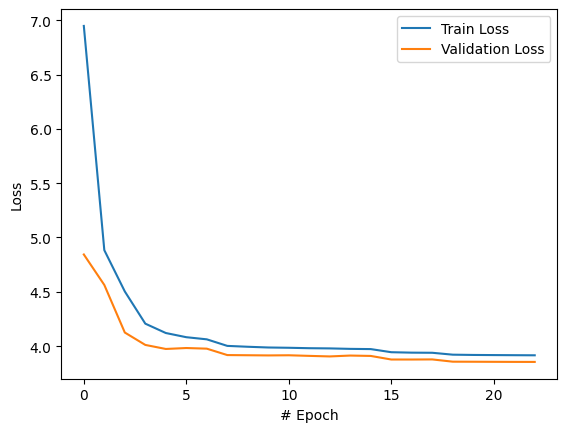

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8545781190379804 to 3.854427921539273
Epoch:  24/50 | Training pTLoss:  3.9145290426214943 | Testing pTLoss:  3.854427921539273


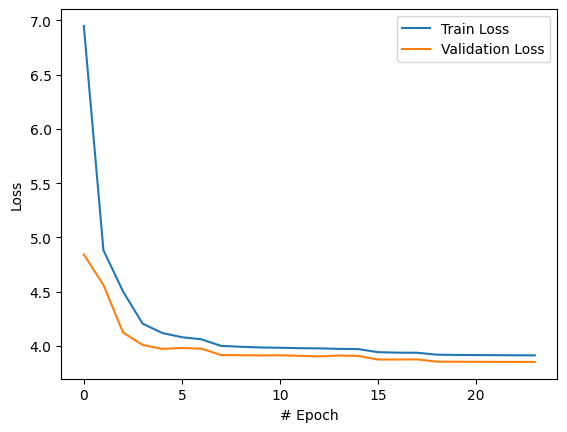

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.854427921539273 to 3.853438663896407
Epoch:  25/50 | Training pTLoss:  3.9137348436998964 | Testing pTLoss:  3.853438663896407


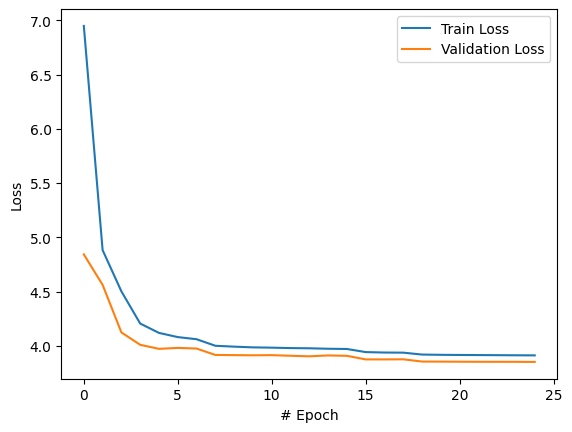

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  26/50 | Training pTLoss:  3.912985967969175 | Testing pTLoss:  3.8535319191773376


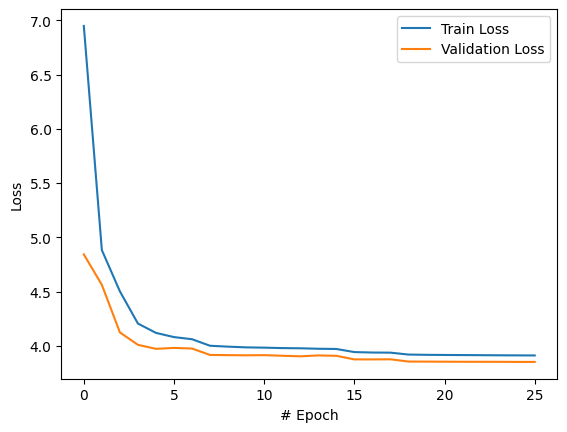

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  27/50 | Training pTLoss:  3.9121074591179497 | Testing pTLoss:  3.8535425042382028


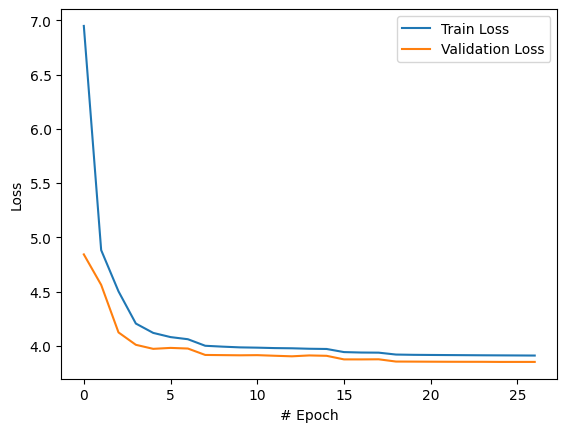

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.853438663896407 to 3.8444740878268617
Epoch:  28/50 | Training pTLoss:  3.903385533686572 | Testing pTLoss:  3.8444740878268617


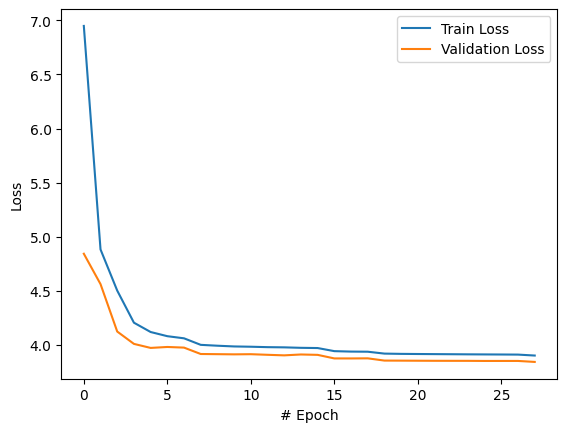

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8444740878268617 to 3.843849384086511
Epoch:  29/50 | Training pTLoss:  3.901895769764701 | Testing pTLoss:  3.843849384086511


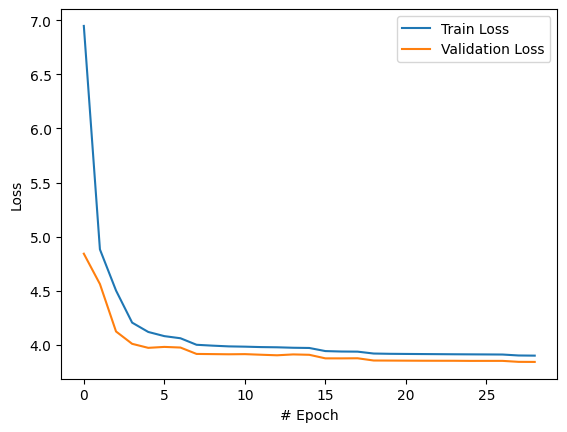

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.843849384086511 to 3.843245025570638
Epoch:  30/50 | Training pTLoss:  3.901306153378099 | Testing pTLoss:  3.843245025570638


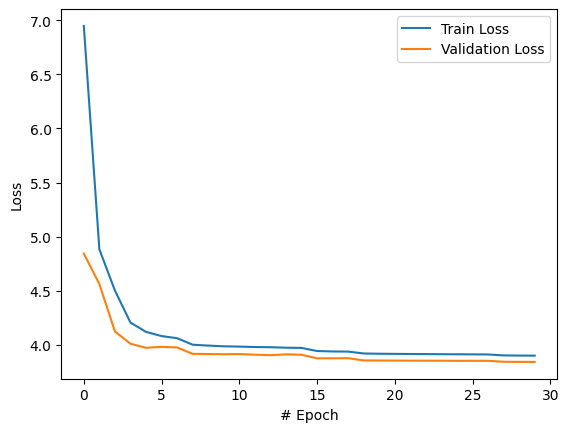

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.843245025570638 to 3.842720731737301
Epoch:  31/50 | Training pTLoss:  3.900691051157329 | Testing pTLoss:  3.842720731737301


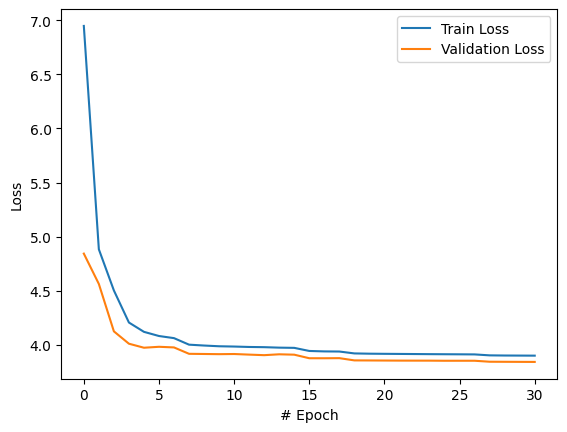

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.842720731737301 to 3.8424022215824567
Epoch:  32/50 | Training pTLoss:  3.900230610577501 | Testing pTLoss:  3.8424022215824567


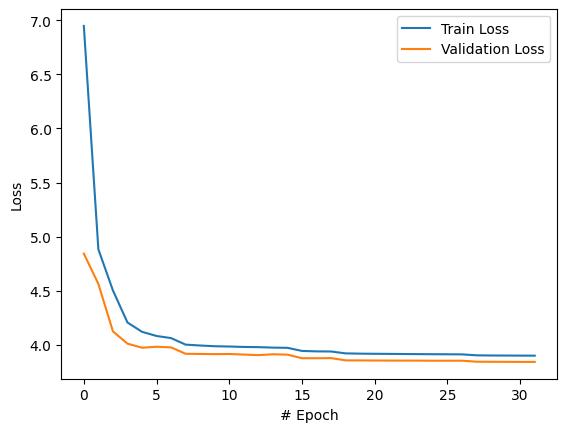

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8424022215824567 to 3.84210416939667
Epoch:  33/50 | Training pTLoss:  3.8997034012883454 | Testing pTLoss:  3.84210416939667


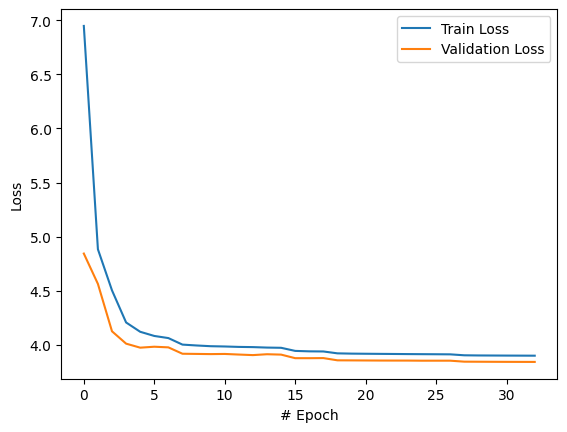

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.84210416939667 to 3.841900946519899
Epoch:  34/50 | Training pTLoss:  3.899235660755714 | Testing pTLoss:  3.841900946519899


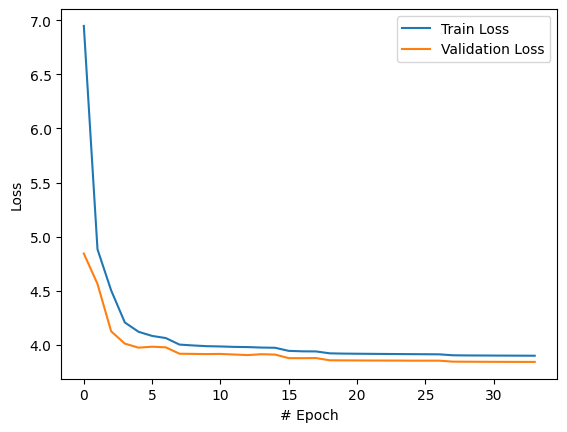

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.841900946519899 to 3.8415835769988482
Epoch:  35/50 | Training pTLoss:  3.89869017003674 | Testing pTLoss:  3.8415835769988482


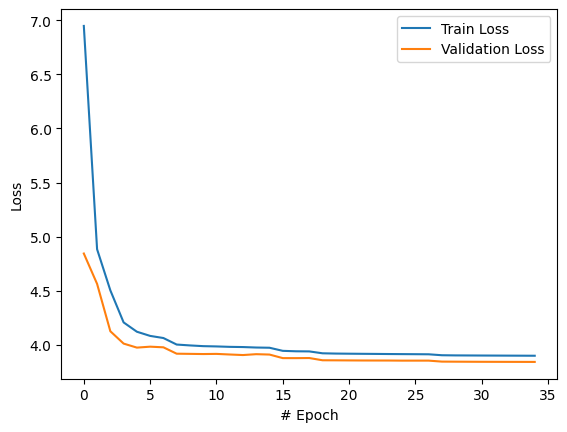

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8415835769988482 to 3.841395568951088
Epoch:  36/50 | Training pTLoss:  3.8981964778227733 | Testing pTLoss:  3.841395568951088


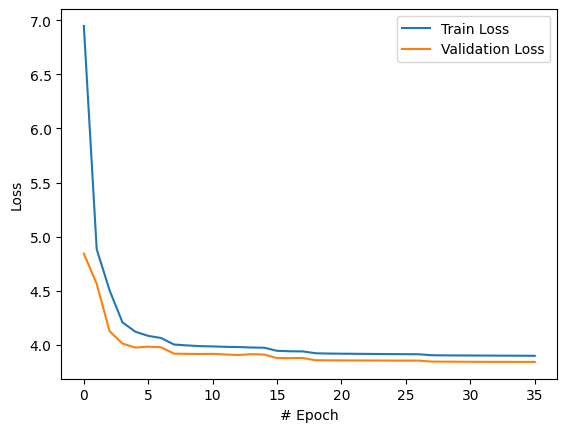

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.841395568951088 to 3.8409580087972066
Epoch:  37/50 | Training pTLoss:  3.897717518687502 | Testing pTLoss:  3.8409580087972066


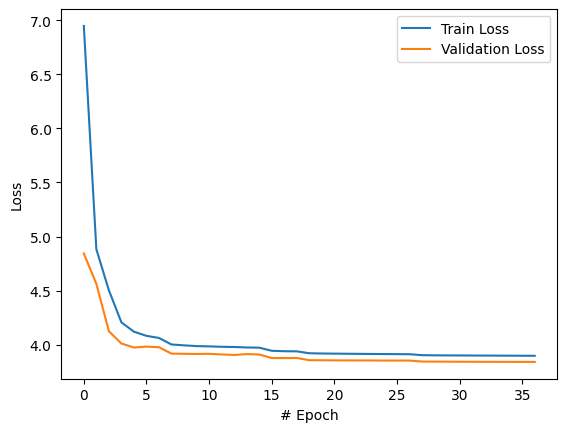

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8409580087972066 to 3.8406753007346794
Epoch:  38/50 | Training pTLoss:  3.89722270200154 | Testing pTLoss:  3.8406753007346794


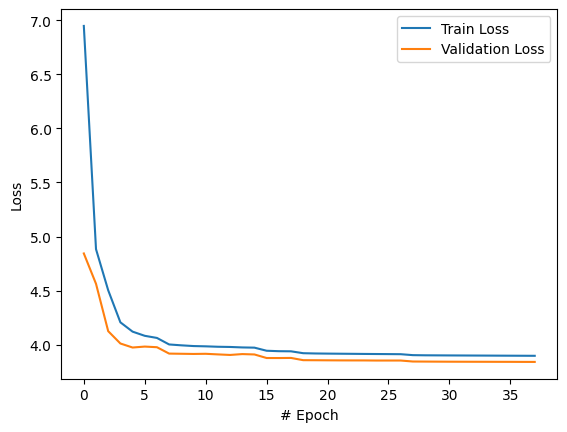

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8406753007346794 to 3.840607611579647
Epoch 00039: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  39/50 | Training pTLoss:  3.8967104066737033 | Testing pTLoss:  3.840607611579647


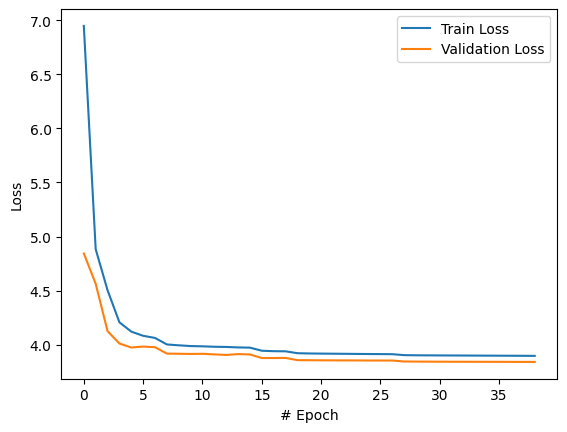

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.840607611579647 to 3.8394858469932047
Epoch:  40/50 | Training pTLoss:  3.8920423372965804 | Testing pTLoss:  3.8394858469932047


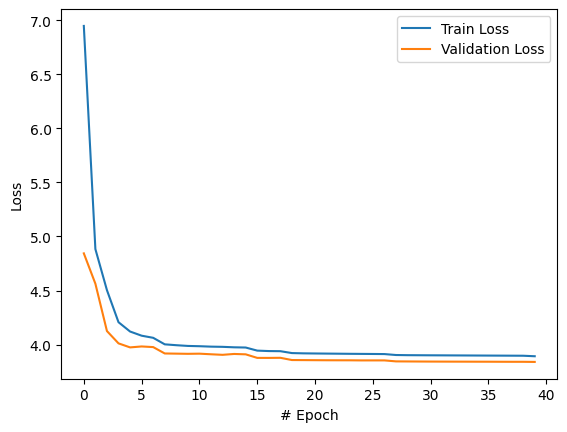

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8394858469932047 to 3.8391220259304433
Epoch:  41/50 | Training pTLoss:  3.891132969530445 | Testing pTLoss:  3.8391220259304433


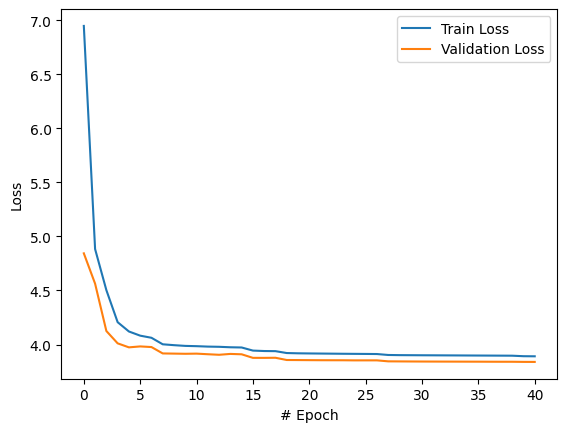

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8391220259304433 to 3.8388690826949703
Epoch:  42/50 | Training pTLoss:  3.890772803227963 | Testing pTLoss:  3.8388690826949703


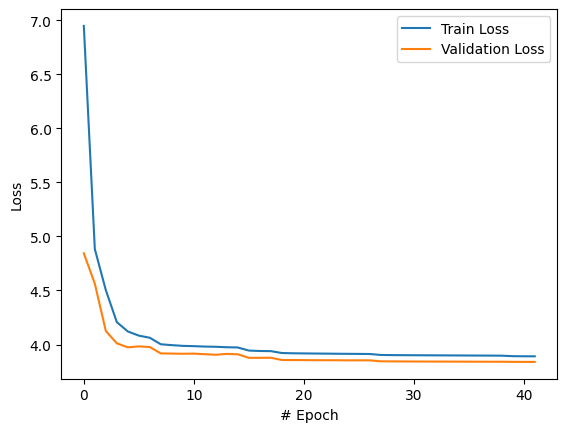

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8388690826949703 to 3.8386787677793888
Epoch:  43/50 | Training pTLoss:  3.890458014290661 | Testing pTLoss:  3.8386787677793888


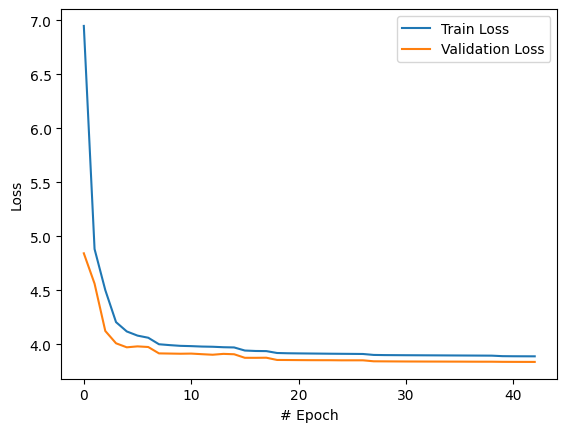

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8386787677793888 to 3.838475942611693
Epoch:  44/50 | Training pTLoss:  3.8901694537243476 | Testing pTLoss:  3.838475942611693


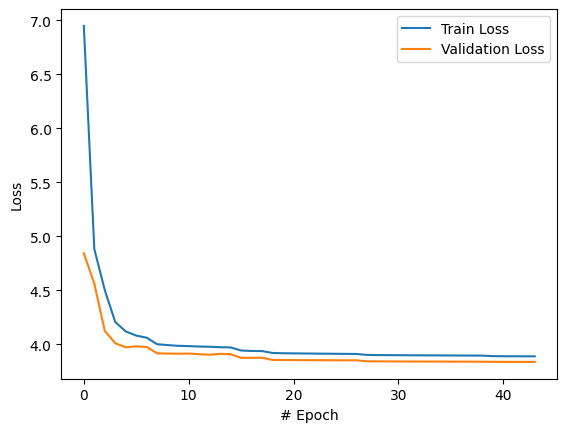

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.838475942611693 to 3.8383692407297714
Epoch:  45/50 | Training pTLoss:  3.8899142275404786 | Testing pTLoss:  3.8383692407297714


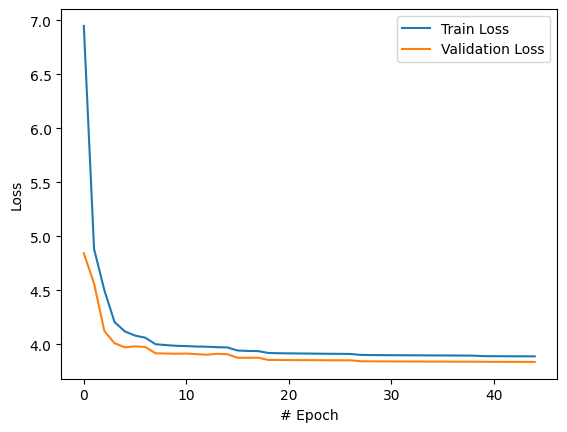

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.8383692407297714 to 3.838275157448526
Epoch 00046: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  46/50 | Training pTLoss:  3.889594643079798 | Testing pTLoss:  3.838275157448526


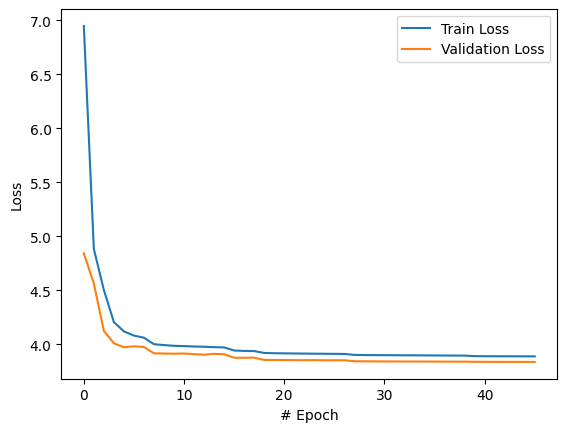

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch:  47/50 | Training pTLoss:  3.886969046711664 | Testing pTLoss:  3.8387673343339874


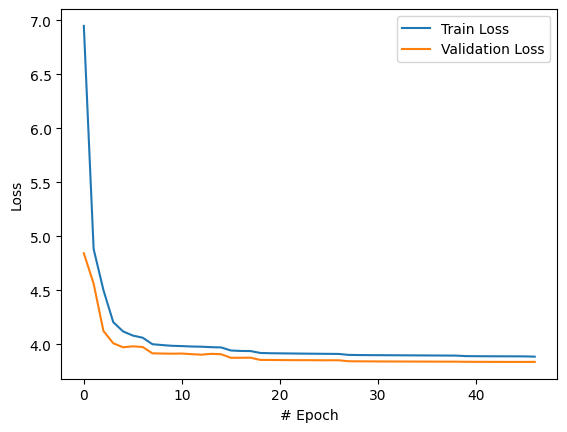

  0%|          | 0/922 [00:00<?, ?it/s]

Epoch 00048: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  48/50 | Training pTLoss:  3.8864956600288525 | Testing pTLoss:  3.8387196544969946


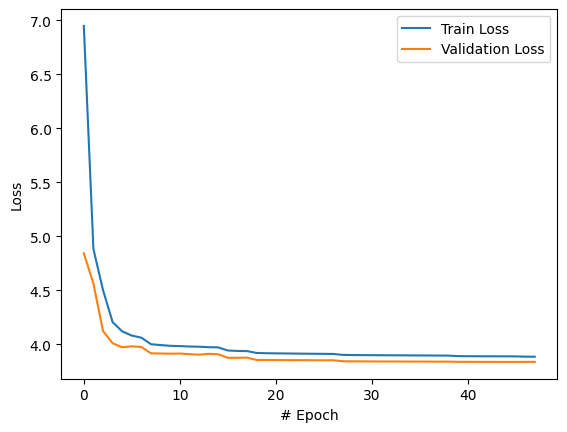

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.838275157448526 to 3.838072002839109
Epoch:  49/50 | Training pTLoss:  3.884975909023123 | Testing pTLoss:  3.838072002839109


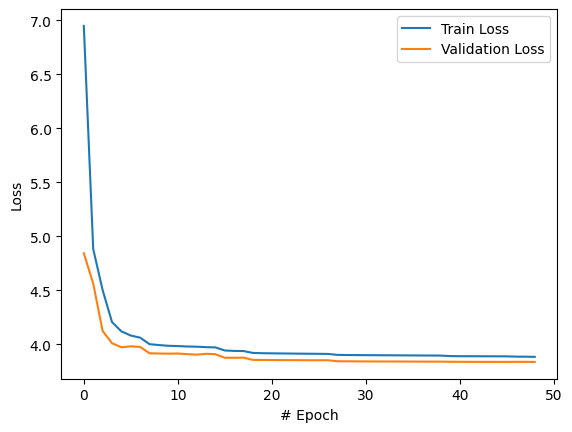

  0%|          | 0/922 [00:00<?, ?it/s]

Min loss changed from 3.838072002839109 to 3.8380501187545906
Epoch:  50/50 | Training pTLoss:  3.884759163649638 | Testing pTLoss:  3.8380501187545906


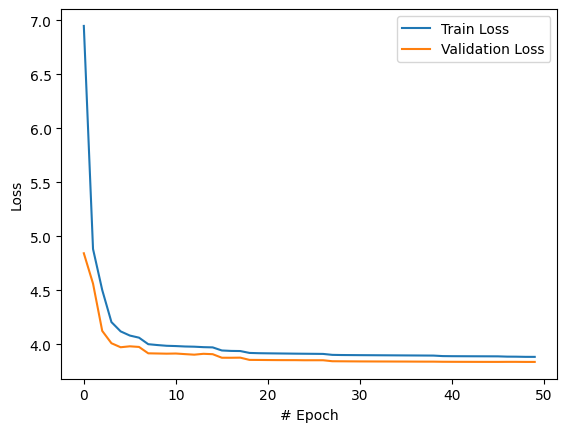

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

## Metrics

In [31]:
def f1_comp(y_true,y_pred):
    f1 = []
    for i in range(100): 
        grnd = y_true >= i
        pred = y_pred >= i
        f1.append(sklearn.metrics.f1_score(grnd,pred))
    return f1

def acc_comp(y_true,y_pred):
    acc = []
    for i in range(100):
        grnd = y_true >= i
        pred = y_pred >= i
        cmp = np.sum(np.equal(grnd,np.squeeze(pred))) 
        acc.append(cmp/len(grnd)*100)
    return acc

In [32]:
# model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
model_name = "/kaggle/input/converting-to-graphs-eachstation-node/model_trained/4GCN_Conv_lossno_inv_.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [33]:
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [34]:
y_true_all = []
y_pred_all = []
# Assuming you have a test_loader and a model
test_los = 0
loaded_model.eval()
with torch.no_grad():
    for data in tqdm(test_loader, position=0):
        data = data.to(device)
        out = loaded_model(data)
#         preds.append(out.cpu().detach())
        
        # Collect true labels and predictions
        labels = data.y.cpu().numpy()
        y_true_all.extend(labels)
        y_pred_all.extend(out.cpu().detach().numpy())
        
        loss = pTLossTorch(out, data.y)
        test_los += loss.cpu().detach().numpy() / len(test_loader)

# Convert collected labels and predictions to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Calculate F1 scores and accuracy
f1_scores = f1_comp(y_true_all, y_pred_all)
accuracy_scores = acc_comp(y_true_all, y_pred_all)

# Calculate MAE
mae = sklearn.metrics.mean_absolute_error(y_true_all, y_pred_all)

100%|██████████| 461/461 [00:28<00:00, 16.42it/s]


In [35]:
# Print results
print('Test_loss:', test_los)
print("F1 Scores:", f1_scores[-1])
print("Accuracy Scores:", accuracy_scores[-1])
print("Mean Absolute Error (MAE):", mae)

Test_loss: 3.8392254918361157
F1 Scores: 0.1674741717135732
Accuracy Scores: 80.18501560168227
Mean Absolute Error (MAE): 43.210644


In [36]:
import csv

# Data to be saved
results = {
    'Test_loss': test_los,
    'F1_Score': f1_scores[-1],
    'Accuracy_Score': accuracy_scores[-1],
    'MAE': mae
}

# Save to CSV
with open('evaluation_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in results.items():
        writer.writerow([key, value])

print('Results saved to evaluation_results.csv')

Results saved to evaluation_results.csv
